# Read in the data

In [10]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [11]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [12]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [13]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [14]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [15]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [16]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [17]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [18]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Parent/Teacher/Student Survey Correlations

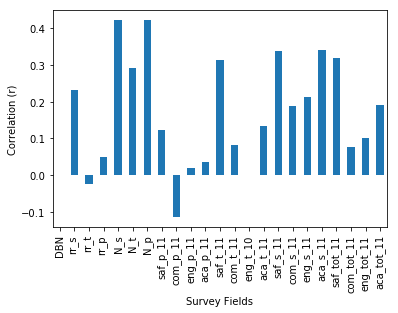

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

correlations[survey_fields].plot.bar()
plt.xlabel('Survey Fields')
plt.ylabel('Correlation (r)')
plt.show()

The plot shows the correlations between a number of survey questions and sat performance for the data set. 

There is correlation found in each of N_s, N_t, and N_p, which are the number of students, teachers, and parents responding, with sat_score. This is in line with the general correlation found with total enrollment which is discussed in the next plot.

There is also noticable correlation found in the safety and respect scores as judged by both students and teachers. Schools with higher safety and respect scores showed some correlation with higher test scores.

The rate of teachers and parents responding to the survey showed no real correlation, but the rate of students responding showed some positive correlation with test scores. This could correspond to overall student involvement being tied to test performance.

The other noticable correlation was with the academic expectations score, especially from students. The schools where the students felt higher academic expectations correlated with higher test scores. 

## Total Enrollment Correlation Examined

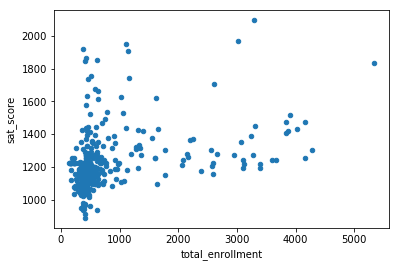

In [22]:
combined.plot.scatter(x='total_enrollment',y='sat_score')

While there is a correlation of r=0.37 between total enrollment and SAT score, the scatter plot does not reveal much of a correlation. There is no noticable pattern of an increased total number of students leading to higher test scores.

Much of the correlation could be coming from the fact that there is a large cluster of small schools with low SAT scores.

## Safety Score Correlation Examined

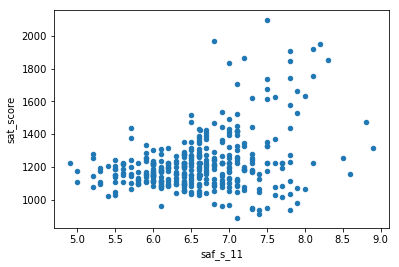

In [23]:
combined.plot.scatter(x='saf_s_11',y='sat_score')

There is a correlation of r=0.34 and it does show up in the scatter plot. There is a large cluster of schools with low SAT and safety scores, and there is a slight general trend. Every school with an SAT score above 1500 also had a safety score above 6.5.

C:\Users\Michael\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\Michael\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


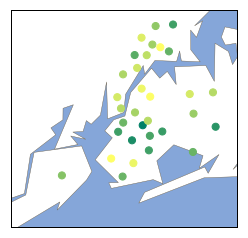

In [42]:
from mpl_toolkits.basemap import Basemap

dist = combined.groupby('school_dist').agg(numpy.mean)
dist.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.5, 
    urcrnrlat=40.9, 
    llcrnrlon=-74.25, 
    urcrnrlon=-73.7,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = dist['lon'].tolist()
latitudes = dist['lat'].tolist()
m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True,c=dist['saf_s_11'],cmap='summer')

A data is aggregated by district and a map is produced to display the safety scores, to further examine it's correlation with SAT score and determine if it is locationally based. The districts with higher safety scores are shaded more green, and the districts with lower scores are more yellow.

Low safety scores are observed in parts of the Bronx and Queens, with a cluster of high scores in Brooklyn.

## Examining Race and SAT Scores

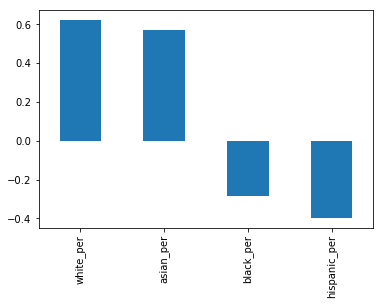

In [27]:
race_col = ['white_per','asian_per','black_per','hispanic_per']
correlations[race_col].plot.bar()

The plot above shows considereble positive correlations between SAT scores and the percentages of white and asian students. 

There is also negative correlations cound with the percentage of black students and especially with the percentage of hispanic students. 

## Hispanic Percentage and SAT Scores

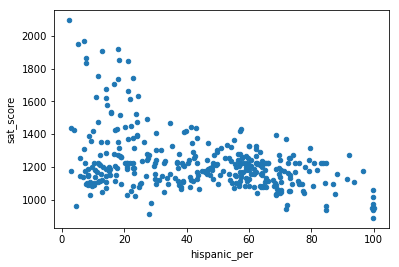

In [28]:
combined.plot.scatter('hispanic_per','sat_score')

The negative correlation seems to be coming from the fact that every school with SAT scores above 500 have fewer than 30% hispanic representation. There is also a cluster of schools with about 100% hispanic representation which all have very low test scores.

In [29]:
hisp_95 = combined[combined['hispanic_per'] > 95]
print(hisp_95[['school_name','sat_score','ell_percent']])

                                           school_name  sat_score  ell_percent
44                       Manhattan Bridges High School     1058.0         72.6
82    Washington Heights Expeditionary Learning School     1174.0         19.6
89   Gregorio Luperon High School for Science and M...     1014.0         89.6
125                Academy for Language and Technology      951.0         86.6
141              International School for Liberal Arts      934.0         79.9
176   Pan American International High School at Monroe      970.0         92.9
253                          Multicultural High School      887.0         94.6
286             Pan American International High School      951.0         91.3


Upon researching the schools with very high hispanic percentage, it appears that many of them have a very high percentage of English language learners. This is a compelling explanation for the low SAT scores. ell_percent has a correlation with sat_score of -0.4.

In [30]:
sat_1800 = combined[combined['sat_score'] > 1800]
print(sat_1800[['school_name','sat_score','hispanic_per']])

                                           school_name  sat_score  \
5                       Bard High School Early College     1856.0   
37                              Stuyvesant High School     2096.0   
79   High School for Mathematics, Science and Engin...     1847.0   
151                       Bronx High School of Science     1969.0   
155  High School of American Studies at Lehman College     1920.0   
187                     Brooklyn Technical High School     1833.0   
302                        Townsend Harris High School     1910.0   
327  Queens High School for the Sciences at York Co...     1868.0   
356                Staten Island Technical High School     1953.0   

     hispanic_per  
5            18.2  
37            2.4  
79           21.2  
151           7.2  
155          18.0  
187           7.9  
302          12.9  
327           7.9  
356           5.3  


Research of the schools among the higherst performers on the SATs reveals that they are by and large specialty schools with competitive admissions. This explains the high SAT scores. This also means that students likely come from all over, but for whatever reason there are a relatively low number of hispanic students. The overall hispanic population in NYC is 27.5%

## Examining Gender and SAT Scores

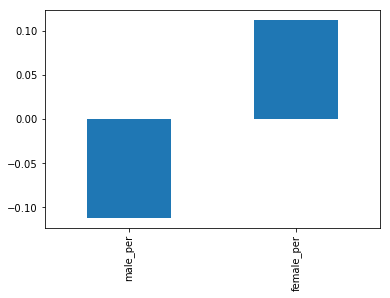

In [31]:
gender_cols = ['male_per','female_per']
correlations[gender_cols].plot.bar()

Gender shows equal and opposite correlations to SAT scores. There is a slight positive correlation with female percentage and a slight negative correlation with male percentage.

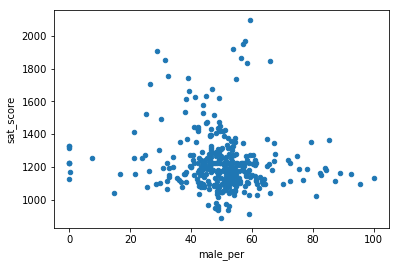

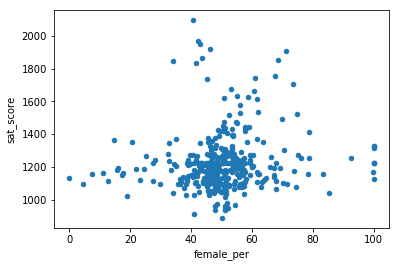

In [32]:
combined.plot.scatter('male_per','sat_score')
combined.plot.scatter('female_per','sat_score')

The correlations are very slight, so no clear pattern is expected in the scatter plots. The very highest performing schools have about 60% males. However, a significant percentage of high performing schools (SAT>1500) are about 60-80% female.

In [33]:
fem_high_sat = combined[(combined['female_per']>60)&(combined['sat_score']>1500)]
print(fem_high_sat[['school_name','sat_score','female_per']])

                                           school_name  sat_score  female_per
5                       Bard High School Early College     1856.0        68.7
22            Professional Performing Arts High School     1522.0        74.7
26                       Eleanor Roosevelt High School     1758.0        67.5
27                              Millennium High School     1614.0        61.8
60                                  Beacon High School     1744.0        61.0
61   Fiorello H. LaGuardia High School of Music & A...     1707.0        73.6
287              Bard High School Early College Queens     1663.0        60.7
302                        Townsend Harris High School     1910.0        71.1
325  Queens Gateway to Health Sciences Secondary Sc...     1538.0        61.9


The schools among that group seem to be some of the same specialty schools as observed before, which would explain high SAT scores. Many of the schools among this subset seem to be focused in the liberal arts.

## Examining AP Scores and SAT Scores

In [34]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

ap_corr = combined.corr()['sat_score']['ap_per']
print(ap_corr)

0.0571708139077


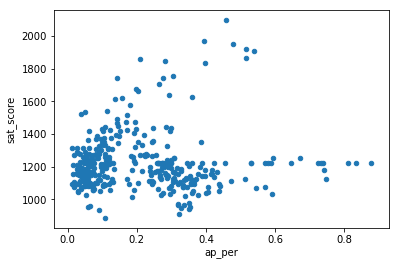

In [35]:
combined.plot.scatter('ap_per','sat_score')

There is a very small r value of 0.06 in this correlation. There does seem to be some relationship between percentage of AP students and SAT scores, but not a very high one. Many of the schools with the highest percentage of AP students are clustered around an SAT score of about 1200.

## Class Size and SAT Scores

0.38101433081


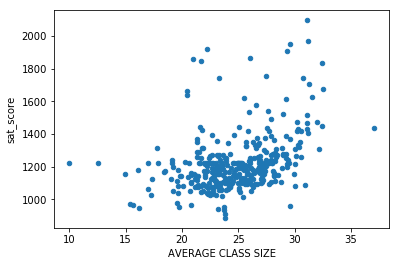

In [39]:
print(combined.corr()['sat_score']['AVERAGE CLASS SIZE'])
combined.plot.scatter('AVERAGE CLASS SIZE','sat_score')

There is a considerable correlation of r=0.38 for average class size, but the scatter plot does not reveal a noticeable pattern. This may be due to a connection with total enrollment.

0.538781881121


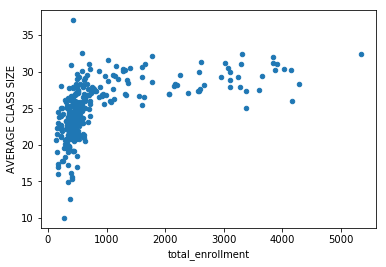

In [41]:
print(combined.corr()['total_enrollment']['AVERAGE CLASS SIZE'])
combined.plot.scatter('total_enrollment','AVERAGE CLASS SIZE')

There is a strong correlation between average class size and total enrollment. Total enrollment was shown before to have a decent correlation coefficient with SAT scores but no noticable pattern of connection. The same can be said for class size, likely due to its association with total enrollment.

## Examining Geographic Correlations

C:\Users\Michael\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\Michael\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


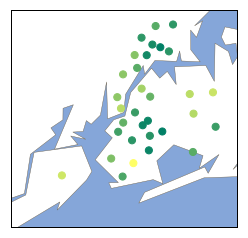

In [44]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.5, 
    urcrnrlat=40.9, 
    llcrnrlon=-74.25, 
    urcrnrlon=-73.7,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = dist['lon'].tolist()
latitudes = dist['lat'].tolist()
m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True,c=dist['sat_score'],cmap='summer')

This map shows a dot for each district, where districts with higher SAT scores are more green and districts with lower scores are more yellow. It can be seen that there are some apparent geographical correlations. Many of the highest performing districts are clustered together in Brooklyn and the Bronx. There are different possible explanations for this, but the first logical correlation with strong schools is funding.

-0.598089291451


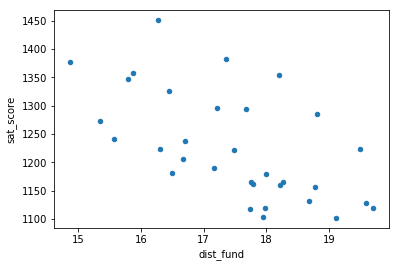

In [71]:
dist_fund = [18.20,17.22,17.68,19.49,18.81,18.27,19.58,18.21,18.67,17.49,17.76,19.10,16.71,17.99,17.17,19.70,17.79,17.74,17.95,15.35,16.68,16.28,18.77,15.58,15.87,14.87,16.30,15.79,16.50,16.45,17.35,17.97]

dist['dist_fund'] = dist_fund

print(dist.corr()['dist_fund']['sat_score'])
dist.plot.scatter('dist_fund','sat_score')

The funding for each district is found in data from the New York Federal Reserve. The funding data is in thousands of dollars of spending per student. There is actually a considerable negative correlation with SAT scores of r=-0.6. 

## Analysis of Surveys